In [29]:
# %pip install numpy pandas pillow scikit-learn kagglehub matplotlib ipython
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# !conda install -c conda-forge background-generator -y


In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
import os
import pandas as pd
import numpy as np
import math
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

In [32]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA version:", torch.version.cuda)
    print("Device name:", device)
else:
    device = torch.device("cpu")
    print("CUDA is not available")
    print("Device name:", device)


CUDA is not available
Device name: cpu


In [33]:
class Display:
    @staticmethod
    def image_Display(image):
        if torch.is_tensor(image):
            image = image.detach().cpu().numpy()

        if image.ndim == 1:
            image = image.reshape(28, 28)

        image = image.astype('uint8')  # ensure proper display format

        display(Image.fromarray(image, mode='L'))


In [34]:
# def convert_merged_csv_to_pt(train_csv_path, test_csv_path, pt_path):
#     dtype_map = {'label': 'int64'} | {str(i): 'uint8' for i in range(1, 785)}

#     df_train = pd.read_csv(train_csv_path, dtype=dtype_map, low_memory=False)
#     df_test = pd.read_csv(test_csv_path, dtype=dtype_map, low_memory=False)

#     df = pd.concat([df_train, df_test], ignore_index=True).sample(frac=1, random_state=42)

#     pixel_array = df.drop(columns='label').to_numpy(dtype='float32', copy=True)
#     label_array = df['label'].to_numpy(dtype='int64', copy=True)

#     pixels = torch.from_numpy(pixel_array)
#     labels = torch.from_numpy(label_array)

#     torch.save((pixels, labels), pt_path)
#     print(f"✅ Saved: {pt_path}")

# convert_merged_csv_to_pt("Dataset/mnist_train.csv", "Dataset/mnist_test.csv", "Dataset/mnist.pt")

In [35]:
class Dataset(Dataset):
    def __init__(self, pt_path):
        self.pixels, self.labels = torch.load(pt_path, weights_only=True)

    def __getitem__(self, index):
        return self.pixels[index], self.labels[index]

    def __len__(self):
        return self.labels.size(0)

In [36]:
def benchmark_workers(pt_path="Dataset/mnist.pt", max_workers=12, batch_size=512):
    dataset = Dataset(pt_path)
    indices = np.arange(len(dataset))
    train_idx, _ = train_test_split(indices, test_size=0.2, shuffle=True)
    train_set = Subset(dataset, train_idx)

    print(f"\nBenchmarking num_workers from 0 to {max_workers}...\n")

    for nw in range(max_workers + 1):
        loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
                                             num_workers=nw, pin_memory=True,
                                             persistent_workers=(nw > 0))
        torch.cuda.synchronize() if torch.cuda.is_available() else None
        t0 = time.perf_counter()

        for x, y in loader:
            pass  # simulate one epoch

        torch.cuda.synchronize() if torch.cuda.is_available() else None
        t1 = time.perf_counter()
        print(f"num_workers={nw:<2} | time: {t1 - t0:.3f} sec")

benchmark_workers()


Benchmarking num_workers from 0 to 12...

num_workers=0  | time: 2.193 sec
num_workers=1  | time: 2.743 sec
num_workers=2  | time: 2.297 sec


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


num_workers=3  | time: 2.251 sec


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


num_workers=4  | time: 3.401 sec


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


num_workers=5  | time: 3.093 sec


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


num_workers=6  | time: 2.864 sec


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 7 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


num_workers=7  | time: 2.792 sec


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


num_workers=8  | time: 3.479 sec


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 9 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


num_workers=9  | time: 4.482 sec


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


num_workers=10 | time: 3.296 sec


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 11 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


num_workers=11 | time: 4.387 sec


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


num_workers=12 | time: 4.995 sec


In [37]:
class Dataloaders:
    def __init__(self, dataset_cls):
        self.dataset_cls = dataset_cls

    def get(self, pt_path, batch_size=None, test_size=0.09, num_workers=0):
        dataset = self.dataset_cls(pt_path)

        indices = np.arange(len(dataset))
        train_idx, test_idx = train_test_split(indices, test_size=test_size, shuffle=True)

        train_set = Subset(dataset, train_idx)
        test_set = Subset(dataset, test_idx)

        effective_batch_size = len(train_set) if batch_size is None else batch_size

        train_loader = DataLoader(train_set, batch_size=effective_batch_size, shuffle=True,
                                  num_workers=num_workers, pin_memory=True,
                                  persistent_workers=(num_workers > 0))

        test_loader = DataLoader(test_set, batch_size=len(test_set) if batch_size is None else batch_size,
                                 shuffle=False, num_workers=num_workers, pin_memory=True,
                                 persistent_workers=(num_workers > 0))

        return train_loader, test_loader


In [38]:
loaders = Dataloaders(Dataset)

train_loader, test_loader = loaders.get("Dataset/mnist.pt", batch_size=None)

for x, y in train_loader:
    x = x.to(device, non_blocking=True)
    y = y.to(device, non_blocking=True)

    Display.image_Display(x[1])
    print("Label:", y[1].item())

    print(x.shape, y.shape)
    break


/tmp/ipython-input-33-29157527.py:12: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  display(Image.fromarray(image, mode='L'))


Label: 6
torch.Size([63700, 784]) torch.Size([63700])


In [39]:
class Scaling(nn.Module):
    def __init__(self, input_tensor: torch.Tensor, bounds=(0.0, 255.0)):
        super().__init__()

        self.device = input_tensor.device
        self.input_dtype = input_tensor.dtype

        min_val = input_tensor.min()
        max_val = input_tensor.max()

        lower, upper = map(float, bounds)
        delta_mm = max_val - min_val
        delta_ul = upper - lower

        a = delta_mm + delta_ul
        b = lower * delta_mm + min_val * delta_ul
        c = 2 * delta_mm * delta_ul

        self.register_buffer("a", a)
        self.register_buffer("b", b)
        self.register_buffer("c", c)

    def forward(self, input_tensor: torch.Tensor):
        if self.c == 0: return input_tensor
        return (self.a * input_tensor - self.b) / self.c

    @torch.no_grad()
    def inverse(self, scaled_tensor: torch.Tensor):
        if self.c == 0: return scaled_tensor
        return (self.c * scaled_tensor + self.b) / self.a


In [40]:
class Classifier(nn.Module):
    def __init__(self, categories: int):
        super().__init__()
        self.categories = categories

    def forward(self, labels: torch.Tensor) -> torch.Tensor:
        return F.one_hot(labels.view(-1), num_classes=self.categories).float()

    @torch.no_grad()
    def inverse(self, one_hot_tensor: torch.Tensor) -> torch.Tensor:
        return one_hot_tensor.argmax(dim=1, keepdim=True)


In [41]:
for x, y in train_loader:
    x = x.to(device, non_blocking=True)
    y = y.to(device, non_blocking=True)

    Display.image_Display(x[1])
    print("Label:", y[1].item())

    bounds = (0.0, 255.0)
    Scaling1 = Scaling(x, bounds)
    Classifier1 = Classifier(10).to(device, non_blocking=True)

    x = Scaling1(x)
    y = Classifier1(y)
    x_inverse = Scaling1.inverse(x)
    y_declassified = Classifier1.inverse(y)
    Display.image_Display(x_inverse[1])
    print("Declassified label:", y_declassified[1].item())

    print(x.shape, y.shape)
    break

/tmp/ipython-input-33-29157527.py:12: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  display(Image.fromarray(image, mode='L'))


Label: 2


Declassified label: 2
torch.Size([63700, 784]) torch.Size([63700, 10])


In [42]:
# class NN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.layer_sizes = [784, 107, 26, 10]
#         self.net = nn.Sequential(
#             nn.Linear(self.layer_sizes[0], self.layer_sizes[1], bias=True),
#             nn.Sigmoid(),                       # fused activation
#             nn.Linear(self.layer_sizes[1], self.layer_sizes[2], bias=True),
#             nn.ReLU(inplace=True),              # in‑place
#             nn.Linear(self.layer_sizes[2], self.layer_sizes[3], bias=True),
#             nn.Softmax(dim=1)
#         )

#         nn.init.xavier_uniform_(self.net[0].weight)
#         nn.init.uniform_(self.net[0].bias, -1.0/math.sqrt(self.layer_sizes[0]), 1.0/math.sqrt(self.layer_sizes[0]))
#         nn.init.kaiming_normal_(self.net[2].weight, nonlinearity='relu')
#         nn.init.uniform_(self.net[2].bias, -1.0/math.sqrt(self.layer_sizes[1]), 1.0/math.sqrt(self.layer_sizes[1]))
#         nn.init.xavier_normal_(self.net[4].weight)
#         nn.init.uniform_(self.net[4].bias, -1.0/math.sqrt(self.layer_sizes[2]), 1.0/math.sqrt(self.layer_sizes[2]))

#         self.loss_fn = nn.CrossEntropyLoss()

#     def forward(self, x):
#         x = x.contiguous()
#         return self.net(x)

class VisualNN(nn.Module):
    def __init__(self):
        super().__init__()
# we removed nn.sequential because we want the values of the layers

        self.layer_sizes = [784, 121, 25, 10]
        self.fc1 = nn.Linear(self.layer_sizes[0], self.layer_sizes[1], bias=True)
        self.fc2 = nn.Linear(self.layer_sizes[1], self.layer_sizes[2], bias=True)
        self.fc3 = nn.Linear(self.layer_sizes[2], self.layer_sizes[3], bias=True)

        self.loss_fn = nn.CrossEntropyLoss()
        self.activations = {}

        # Initialize weights & biases
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.uniform_(self.fc1.bias, -1.0 / math.sqrt(self.layer_sizes[0]), 1.0 / math.sqrt(self.layer_sizes[0]))

        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        nn.init.uniform_(self.fc2.bias, -1.0 / math.sqrt(self.layer_sizes[1]), 1.0 / math.sqrt(self.layer_sizes[1]))

        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.uniform_(self.fc3.bias, -1.0 / math.sqrt(self.layer_sizes[2]), 1.0 / math.sqrt(self.layer_sizes[2]))

    def forward(self, x):
        self.activations['input'] = x.detach().cpu()  # (batch_size, 784)

        x = torch.sigmoid(self.fc1(x))
        self.activations['layer1'] = x.detach().cpu()  # (batch_size, 121)

        x = torch.relu(self.fc2(x))
        self.activations['layer2'] = x.detach().cpu()  # (batch_size, 25)

        x = self.fc3(x)
        self.activations['output'] = x.detach().cpu()  # (batch_size, 10)

        return torch.softmax(x, dim=1)


In [47]:
# def visualize_activations(activations, epoch, sample_idx=0):
#     shapes = {
#         'input': (28, 28),
#         'layer1': (11, 11),
#         'layer2': (5, 5),
#         'output': (1, 10)
#     }

#     fig, axs = plt.subplots(1, 4, figsize=(14, 4))

#     for layer_name, ax in zip(shapes.keys(), axs):
#         shape = shapes[layer_name]
#         act = activations[layer_name][sample_idx].view(*shape)
#         ax.imshow(act, cmap='gray')
#         ax.set_title(f"{layer_name} ({shape[0]}×{shape[1]})")
#         ax.axis('off')

#     plt.suptitle(f"Epoch {epoch} - Neuron Activations")
#     plt.tight_layout()
#     plt.show()


def visualize_activations(activations, epoch, sample_idx=0):
    shapes = {
        'input': (28, 28),
        'layer1': (11, 11),
        'layer2': (5, 5),
        'output': (1, 10)
    }

    print(f"\nEpoch {epoch} - Neuron Activations for Sample {sample_idx}:")

    for layer_name in shapes:
        shape = shapes[layer_name]
        act = activations[layer_name][sample_idx].view(*shape)
        print(f"Layer: {layer_name} | Shape: {shape}")
        Display.image_Display(act)


In [48]:
for x, y in train_loader:
    x = x.to(device, non_blocking=True)
    y = y.to(device, non_blocking=True)

    Display.image_Display(x[1])
    print("Label:", y[1].item())

    bounds = (0.0, 255.0)
    Scaling1 = Scaling(x, bounds)
    Classifier1 = Classifier(10).to(device, non_blocking=True)
    net = VisualNN().to(device, non_blocking=True)

    x_scaled = Scaling1(x)
    y_encoded = Classifier1(y)

    yHAT = net(x_scaled)
    loss = net.loss_fn(yHAT, y)
    print("CrossEntropy Loss:", loss.item())

    x_inverse = Scaling1.inverse(x_scaled)
    y_declassified = Classifier1.inverse(y_encoded)
    yHAT_declassified = Classifier1.inverse(yHAT)

    Display.image_Display(x_inverse[1])
    print("Actual:", y_declassified[1].item())
    print("Predicted:", yHAT_declassified[1].item())

    print(x_scaled.shape, y_encoded.shape, yHAT.shape)
    break


/tmp/ipython-input-33-29157527.py:12: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  display(Image.fromarray(image, mode='L'))


Label: 4
CrossEntropy Loss: 2.304145336151123


Actual: 4
Predicted: 8
torch.Size([63700, 784]) torch.Size([63700, 10]) torch.Size([63700, 10])


In [49]:
class UltraFastTrainer:
    def __init__(
        self,
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer_cls=torch.optim.Adam,
        lr=1e-3,
        max_epochs=50,
        clip_grad_norm=1.0,
        use_amp=True,
        use_tqdm=False,
        save_path=None
    ):
        self.model = model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer_cls(model.parameters(), lr=lr)
        self.max_epochs = max_epochs
        self.clip_grad_norm = clip_grad_norm
        self.use_amp = use_amp
        self.save_path = save_path
        self.use_tqdm = use_tqdm

        self.scaler_amp = GradScaler(enabled=use_amp)
        self.loss_history = []

    def _prefetch_loader(self, loader):
        for x, y in loader:
            yield x.to(device, non_blocking=True), y.to(device, non_blocking=True)

    def train(self, train_loader):
        self.model.train()

        x_sample, _ = next(iter(train_loader))
        scaler = Scaling(x_sample.to(device))

        for epoch in range(1, self.max_epochs + 1):
            start = time.perf_counter()
            total_loss = 0.0

            iterable = self._prefetch_loader(train_loader)
            if self.use_tqdm:
                iterable = tqdm(iterable, desc=f"Epoch {epoch}", leave=False)

            for x, y in iterable:
                x = scaler(x)

                self.optimizer.zero_grad(set_to_none=True)

                with autocast(device_type=device.type, enabled=self.use_amp):
                    y_pred = self.model(x)
                    loss = self.loss_fn(y_pred, y)

                if epoch % 15 == 0:  # Show on every 15 epoch
                    visualize_activations(self.model.activations, epoch)


                self.scaler_amp.scale(loss).backward()

                if self.clip_grad_norm:
                    self.scaler_amp.unscale_(self.optimizer)
                    nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_grad_norm)

                self.scaler_amp.step(self.optimizer)
                self.scaler_amp.update()

                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            self.loss_history.append(avg_loss)

            elapsed = time.perf_counter() - start
            print(f"Epoch {epoch:03d} | Loss: {avg_loss:.4f} | Time: {elapsed:.2f}s")

        if self.save_path:
            torch.save(self.model.state_dict(), self.save_path)

    def evaluate(self, test_loader):
        self.model.eval()
        correct, total = 0, 0

        scaler = Scaling(next(iter(test_loader))[0].to(device))

        with torch.no_grad():
            for x, y in self._prefetch_loader(test_loader):
                x = scaler(x)
                pred = self.model(x).argmax(dim=1)
                correct += (pred == y.view(-1)).sum().item()
                total += y.size(0)

        acc = correct / total
        print(f"Test Accuracy: {acc*100:.2f}%")
        return acc

    def plot_loss(self):
        plt.plot(self.loss_history)
        plt.title("Loss Curve")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


Epoch 001 | Loss: 2.3048 | Time: 3.91s
Epoch 002 | Loss: 2.2979 | Time: 4.27s
Epoch 003 | Loss: 2.2908 | Time: 4.89s
Epoch 004 | Loss: 2.2835 | Time: 3.98s
Epoch 005 | Loss: 2.2758 | Time: 4.28s
Epoch 006 | Loss: 2.2680 | Time: 4.44s
Epoch 007 | Loss: 2.2597 | Time: 4.17s
Epoch 008 | Loss: 2.2510 | Time: 3.97s
Epoch 009 | Loss: 2.2418 | Time: 4.06s
Epoch 010 | Loss: 2.2321 | Time: 4.82s
Epoch 011 | Loss: 2.2221 | Time: 3.97s
Epoch 012 | Loss: 2.2123 | Time: 4.11s
Epoch 013 | Loss: 2.2028 | Time: 4.60s
Epoch 014 | Loss: 2.1937 | Time: 3.73s

Epoch 15 - Neuron Activations for Sample 0:
Layer: input | Shape: (28, 28)


/tmp/ipython-input-33-29157527.py:12: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  display(Image.fromarray(image, mode='L'))


Layer: layer1 | Shape: (11, 11)


Layer: layer2 | Shape: (5, 5)


Layer: output | Shape: (1, 10)


Epoch 015 | Loss: 2.1848 | Time: 3.93s
Epoch 016 | Loss: 2.1762 | Time: 4.29s
Epoch 017 | Loss: 2.1680 | Time: 4.46s
Epoch 018 | Loss: 2.1601 | Time: 4.24s
Epoch 019 | Loss: 2.1524 | Time: 4.75s
Epoch 020 | Loss: 2.1450 | Time: 4.21s
Epoch 021 | Loss: 2.1377 | Time: 4.20s
Epoch 022 | Loss: 2.1305 | Time: 4.50s
Epoch 023 | Loss: 2.1236 | Time: 4.28s
Epoch 024 | Loss: 2.1168 | Time: 3.74s
Epoch 025 | Loss: 2.1102 | Time: 4.04s
Epoch 026 | Loss: 2.1038 | Time: 4.92s
Epoch 027 | Loss: 2.0974 | Time: 3.98s
Epoch 028 | Loss: 2.0912 | Time: 4.08s
Epoch 029 | Loss: 2.0851 | Time: 4.82s

Epoch 30 - Neuron Activations for Sample 0:
Layer: input | Shape: (28, 28)


Layer: layer1 | Shape: (11, 11)


Layer: layer2 | Shape: (5, 5)


Layer: output | Shape: (1, 10)


Epoch 030 | Loss: 2.0791 | Time: 3.91s
Epoch 031 | Loss: 2.0731 | Time: 4.11s
Epoch 032 | Loss: 2.0669 | Time: 5.74s
Epoch 033 | Loss: 2.0607 | Time: 4.60s
Epoch 034 | Loss: 2.0542 | Time: 4.14s
Epoch 035 | Loss: 2.0476 | Time: 4.49s
Epoch 036 | Loss: 2.0408 | Time: 4.82s
Epoch 037 | Loss: 2.0339 | Time: 3.89s
Epoch 038 | Loss: 2.0267 | Time: 5.16s
Epoch 039 | Loss: 2.0195 | Time: 5.03s
Epoch 040 | Loss: 2.0121 | Time: 4.52s
Epoch 041 | Loss: 2.0047 | Time: 4.02s
Epoch 042 | Loss: 1.9973 | Time: 4.78s
Epoch 043 | Loss: 1.9899 | Time: 3.91s
Epoch 044 | Loss: 1.9824 | Time: 3.93s

Epoch 45 - Neuron Activations for Sample 0:
Layer: input | Shape: (28, 28)


Layer: layer1 | Shape: (11, 11)


Layer: layer2 | Shape: (5, 5)


Layer: output | Shape: (1, 10)


Epoch 045 | Loss: 1.9748 | Time: 4.45s
Epoch 046 | Loss: 1.9671 | Time: 3.84s
Epoch 047 | Loss: 1.9592 | Time: 3.94s
Epoch 048 | Loss: 1.9513 | Time: 3.89s
Epoch 049 | Loss: 1.9435 | Time: 4.32s
Epoch 050 | Loss: 1.9360 | Time: 4.10s
Epoch 051 | Loss: 1.9290 | Time: 3.90s
Epoch 052 | Loss: 1.9222 | Time: 4.43s
Epoch 053 | Loss: 1.9154 | Time: 3.75s
Epoch 054 | Loss: 1.9086 | Time: 4.36s
Epoch 055 | Loss: 1.9017 | Time: 4.23s
Epoch 056 | Loss: 1.8945 | Time: 4.44s
Epoch 057 | Loss: 1.8873 | Time: 3.99s
Epoch 058 | Loss: 1.8800 | Time: 3.84s
Epoch 059 | Loss: 1.8725 | Time: 4.38s

Epoch 60 - Neuron Activations for Sample 0:
Layer: input | Shape: (28, 28)


Layer: layer1 | Shape: (11, 11)


Layer: layer2 | Shape: (5, 5)


Layer: output | Shape: (1, 10)


Epoch 060 | Loss: 1.8652 | Time: 3.98s
Epoch 061 | Loss: 1.8581 | Time: 4.29s
Epoch 062 | Loss: 1.8514 | Time: 4.27s
Epoch 063 | Loss: 1.8453 | Time: 3.69s
Epoch 064 | Loss: 1.8395 | Time: 4.78s
Epoch 065 | Loss: 1.8340 | Time: 5.17s
Epoch 066 | Loss: 1.8284 | Time: 3.98s
Epoch 067 | Loss: 1.8228 | Time: 3.78s
Epoch 068 | Loss: 1.8172 | Time: 4.54s
Epoch 069 | Loss: 1.8121 | Time: 4.11s
Epoch 070 | Loss: 1.8074 | Time: 4.11s
Epoch 071 | Loss: 1.8032 | Time: 4.18s
Epoch 072 | Loss: 1.7993 | Time: 4.28s
Epoch 073 | Loss: 1.7956 | Time: 4.05s
Epoch 074 | Loss: 1.7919 | Time: 4.20s

Epoch 75 - Neuron Activations for Sample 0:
Layer: input | Shape: (28, 28)


Layer: layer1 | Shape: (11, 11)


Layer: layer2 | Shape: (5, 5)


Layer: output | Shape: (1, 10)


Epoch 075 | Loss: 1.7884 | Time: 5.56s
Epoch 076 | Loss: 1.7850 | Time: 3.69s
Epoch 077 | Loss: 1.7818 | Time: 4.03s
Epoch 078 | Loss: 1.7787 | Time: 8.53s
Epoch 079 | Loss: 1.7757 | Time: 6.86s
Epoch 080 | Loss: 1.7728 | Time: 4.51s
Epoch 081 | Loss: 1.7699 | Time: 4.74s
Epoch 082 | Loss: 1.7670 | Time: 3.93s
Epoch 083 | Loss: 1.7640 | Time: 4.92s
Epoch 084 | Loss: 1.7609 | Time: 5.42s
Epoch 085 | Loss: 1.7577 | Time: 4.33s
Epoch 086 | Loss: 1.7543 | Time: 3.57s
Epoch 087 | Loss: 1.7506 | Time: 4.78s
Epoch 088 | Loss: 1.7469 | Time: 4.82s
Epoch 089 | Loss: 1.7430 | Time: 4.02s

Epoch 90 - Neuron Activations for Sample 0:
Layer: input | Shape: (28, 28)


Layer: layer1 | Shape: (11, 11)


Layer: layer2 | Shape: (5, 5)


Layer: output | Shape: (1, 10)


Epoch 090 | Loss: 1.7392 | Time: 4.17s
Epoch 091 | Loss: 1.7357 | Time: 4.10s
Epoch 092 | Loss: 1.7325 | Time: 3.88s
Epoch 093 | Loss: 1.7295 | Time: 3.46s
Epoch 094 | Loss: 1.7265 | Time: 4.40s
Epoch 095 | Loss: 1.7232 | Time: 3.84s
Epoch 096 | Loss: 1.7199 | Time: 3.77s
Epoch 097 | Loss: 1.7165 | Time: 4.06s
Epoch 098 | Loss: 1.7134 | Time: 4.58s
Epoch 099 | Loss: 1.7104 | Time: 3.98s
Epoch 100 | Loss: 1.7075 | Time: 4.27s
Test Accuracy: 81.33%


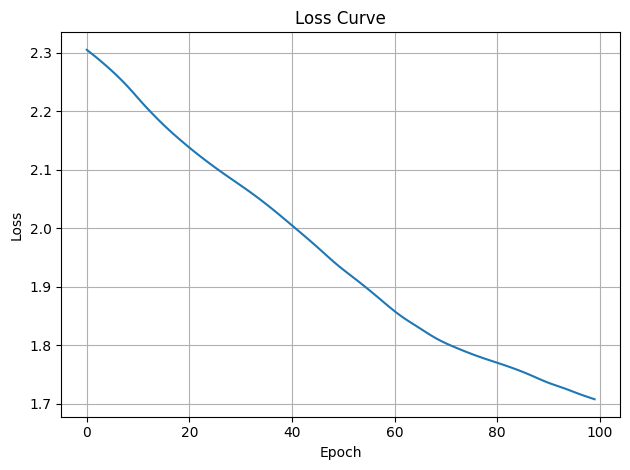

In [50]:
model = VisualNN()
trainer = UltraFastTrainer(model, nn.CrossEntropyLoss(), max_epochs=100, use_amp=False)

trainer.train(train_loader)
trainer.evaluate(test_loader)
trainer.plot_loss()
